# ExploreModel
In this code we aim to explore the model problem
$$y' = \lambda y,\quad y(0) = 1$$
where observations are of the form
$$z_i = y(t_i) + \varepsilon_i,\quad \varepsilon_i \sim \mathcal{N}(0,\sigma),$$
and the unknown is $\lambda$.

In [1]:
# load packages
import numpy as np
import pandas as pd

from math import exp, pi

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(0)

In [2]:
from notebook.nbextensions import _get_nbextension_dir
_get_nbextension_dir(user=True)

'/home/rober323/.local/share/jupyter/nbextensions'

Consider $\lambda$ = -2.5, a discretization $\Delta t$, on the interval $t = [0,1]$

In [3]:
lam = -2.5
delta_t = 0.1
interval_T = [0,1]

The Analytical solution to the model problem follows
$$ y(t) = e^{\lambda t}.$$
Generate a vector $y$ on the interval $t$ with the given discretization $\Delta t$

In [4]:
def model_analytic(constant, t_vec):
    y = np.zeros(len(t_vec))
    for i in range(len(t_vec)):
        t = t_vec[i]    
        if(t == 0):
            y[i] = 1
        else:
            y[i] = exp(constant*t)
    return(y)

In [5]:
num_step = int((interval_T[1]-interval_T[0])/delta_t) ## needs to be integer, because: "number of steps"
t_vec = np.linspace(start=interval_T[0], stop=interval_T[1], num=num_step)
y_vec = model_analytic(lam, t_vec)

Plot the solution as a scatter plot

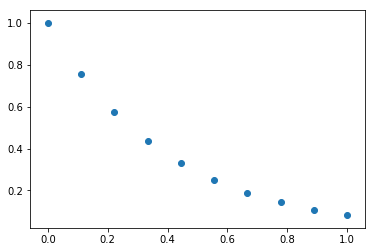

In [6]:
plt.scatter(x=t_vec,y=y_vec)
plt.show()

This is the underlying truth.

Now, consider noisy observations, $z_i = y(t_i) + \varepsilon_i$,
where $\varepsilon_i \sim \mathcal{N}(0,\sigma)$, and $\sigma = 1$ 

In [7]:
def observation(y_vec, scale):
    z_vec = y_vec + np.random.normal(loc=0,scale=scale, size=len(y_vec))
    return(z_vec)

In [8]:
scale = 1
z_0 = observation(y_vec, scale)
z_1 = observation(y_vec, scale)

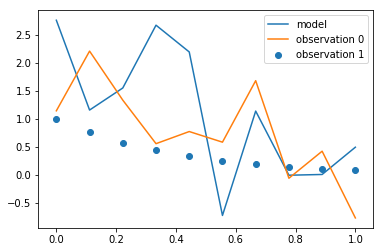

In [9]:
plt.scatter(t_vec, y_vec)
plt.plot(t_vec, z_0, '-')
plt.plot(t_vec, z_1, '-')

plt.legend(["model","observation 0", "observation 1"])
plt.show()

Now consider $N_\text{samples}$ of $z$.

In [10]:
df = pd.DataFrame({"t": t_vec, "y":y_vec})
N_samples = 100
for n in range(N_samples):
    name = "z_" + str(n)
    df[name] = observation(y_vec, scale)



plot all $N_\text{samples}$

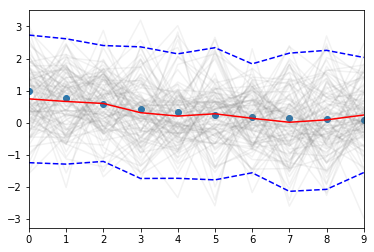

In [11]:
df.iloc[:,2:].plot(color="grey", alpha=0.1, legend=False)
## moments
df_mean = df.iloc[:,2:].mean(axis=1)
df_std = df.iloc[:,2:].std(axis=1)
plt.plot(df_mean, color="red")
plt.plot(df_mean + 2*df_std, "--b")
plt.plot(df_mean - 2*df_std, "--b")

## observation
plt.scatter(x=range(len(y_vec)), y = y_vec)
plt.show()

# SMC-sampler

Now, consider given the observation. Can we find the unknown random variable $\lambda$ via Bayesian Inversion?

Assume the prior $P(\lambda) = \mathcal{N}(0,1)$,

additative normal dist. noise, $\varepsilon \sim \mathcal{N}(0,\sigma)$.

We then have the likelihood, for a observation (series) $\mathbf{z} = (z_0, z_1, \dots, z_N)$,
$P(\mathbf{z} | \lambda) = \frac{1}{{2\pi}^{k/2} \sigma^k} \exp{\big( \frac{-1}{2 \sigma^2} \sum_i^N |G(\cdot,t_i) - z_i|^2 \big)}$

### Deploy a (boring) Metropolis-Hastings algorithm

In [12]:
def prior(eps, loc, scale, log=False):
    if(log):
        pdf = norm.logpdf(eps, loc, scale)
    else:
        pdf = norm.pdf(eps, loc, scale)
    return(pdf)


In [282]:
# use a class structre
class MetropolisHastings:
    # in proposal we need a step lenght
    def __init__(self, prior, noise, delta_T, log, random_state=0):
        self.random_state = random_state
        self.posterior = np.empty([0])
        self.likelihood_traj = np.empty([0])
        self.prior = prior
        self.noise = noise
        self.delta_T = delta_T
        self.log = log
        
    def reSeed(self, random_state):
        self.random_state=random_state
                        
    # find the posterior given the observation
    def fit(self, data, N_sample, start, step, silent = False):
        np.random.seed(self.random_state)
        posterior = np.empty([N_sample])
        likelihood_traj = np.empty([N_sample])
        
        if(not silent):
            print("run loop for: ", N_sample)
        
        posterior[0] = start
        ## compute likelihood P(z|start)
        p_old = self.likelihood(data, start)
        likelihood_traj[0] = p_old
        ## compute prior P(start)
        prior_old = prior(start, self.prior.loc, self.prior.scale, self.prior.log)
        
        ## keep track of acceptance rate
        acc_rate = 0
        for i in range(N_sample-1):
            ## propose new parameter
            theta_prop = posterior[i] + step*np.random.normal(size=1)
            
            ## compute likelihood P(z|theta_prop)
            p_prop = self.likelihood(data, theta_prop)
            
            ## compute prior P(theta_prop)
            prior_prop = prior(theta_prop, self.prior.loc, self.prior.scale, self.prior.log)
            
            ## compute acceptance rate
            if(self.log):
                a = np.exp( (p_prop + prior_prop) - (p_old + prior_old))
            else:
                a = (p_prop * prior_prop) / (p_old * prior_old)
                
            #a = np.min([1, a_0])
            ## draw flip a coin to see outcome of acceptance
            u = np.random.uniform(0,1,1)
            
            if(u < a): ## accept
                #print("theta: ", theta_prop, "like:", p_prop, "like_old", p_old, "a0 :", a_0)
                posterior[i+1], likelihood_traj[i+1] = theta_prop, p_prop
                p_old, prior_old = p_prop, prior_prop
                acc_rate += 1
            else:
                posterior[i+1], likelihood_traj[i+1] = posterior[i], likelihood_traj[i]

        acc_rate /= N_sample
        
        if(not silent):
            print("acceptance rate: ", acc_rate)
        
        self.likelihood_traj = likelihood_traj
        self.posterior = posterior
        

    def likelihood(self, obs, theta):
        ## generate series
        y = self.model(theta)
        N_time = len(y)
        N_data = obs.shape[1]
        
        
        diff = (obs - y)**2
        #print("matrix: ", diff, ", shape ", diff.shape)
        #diff_mean = np.mean(diff, axis = 0) ## size N_time, the mean weight at each time point
        #print("mean: ", diff_mean, ", shape ", diff_mean.shape)
        #diff_sum = np.sum(diff_mean) ## size 1, the sum of all weights,
        diff_sum = np.sum(diff, axis = 1) ## size N_data, the sum of all weights,
        
        g = -1/(2*self.noise.scale**2) * diff_sum
        
        #print(g)
        
        #print(np.prod(g))
        #g = np.mean(g)
        #print(g)


        h = N_time * np.log((2*pi)**(-2) * self.noise.scale**(-1))
        p = np.sum(g+h)
        
        prob = p
        
        #print("theta: ", theta, "like: ", prob)
        #if(~self.log):
        #    print(self.log)
        #    prob = exp(prob)

        #print(g, g_mean, p,prob)

        
        return(prob)
    
    def model(self, constant):
        t_vec = np.linspace(0,1,int(1/self.delta_T))
        y = np.zeros(len(t_vec))
        for i in range(len(t_vec)):
            t = t_vec[i]    
            if(t == 0):
                y[i] = 1
            else:
                y[i] = exp(constant*t)
        return(y)

    # return posterior
    def getPosterior(self, thin = 0.1):
        post = self.posterior
        post = post[::int(1/thin)]
        return(post)
    
    # return likelihood trajectory
    def getLikelihood(self):
        return(self.likelihood_traj)

    def plot(self):
        plt.figure(figsize=(10,10))
        plt.subplot(2, 2, 1)
        post = self.getPosterior()
        plt.plot(post)
        plt.plot([0, len(post)], [np.mean(post), np.mean(post)],color="red")
        plt.title("posterior walk")

        plt.subplot(2,2,2)
        plt.hist(post)
        plt.title("posterior histogram")


        ax2 = plt.subplot(2,2,3)
        plot_acf(post, ax = ax2)

        like = self.getLikelihood()
        
        plt.subplot(2,2,4)
        plt.plot(like)
        plt.title("likelihood walk")
    
    

In [14]:
class Gprior:
    def __init__(self, loc, scale, log):
        self.loc = loc
        self.scale = scale
        self.log = log

        

Generate an observation, $z_\text{obs}$!

In [289]:
theta_true = -2.5
delta_T = 0.1
t_vec = np.linspace(0,1,int(1/delta_T))
y_true = model_analytic(theta_true, t_vec)
scale = 0.5
N_data = 100
z_obs = np.empty([N_data, len(y_true)])
for i in range(N_data):
    z_obs[i,:] = (observation(y_true, scale))

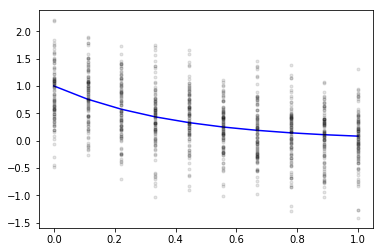

In [300]:
plt.plot(t_vec, y_true, 'b')
for i in range(N_data):
    plt.plot(t_vec, z_obs[i,:], '.k', alpha = 0.1)
plt.show()

Now, infer the parameter

In [298]:
log = True
model = MetropolisHastings(prior=Gprior(0, 10, log), noise=Gprior(0,scale, log), delta_T=delta_T, log=log)

N_sample = 1000
start = -2.5
step = 0.5
N_lookat = 100
model.fit(z_obs[np.random.choice(N_data, N_lookat, replace=False),:], N_sample, start, step)

run loop for:  1000
acceptance rate:  0.332


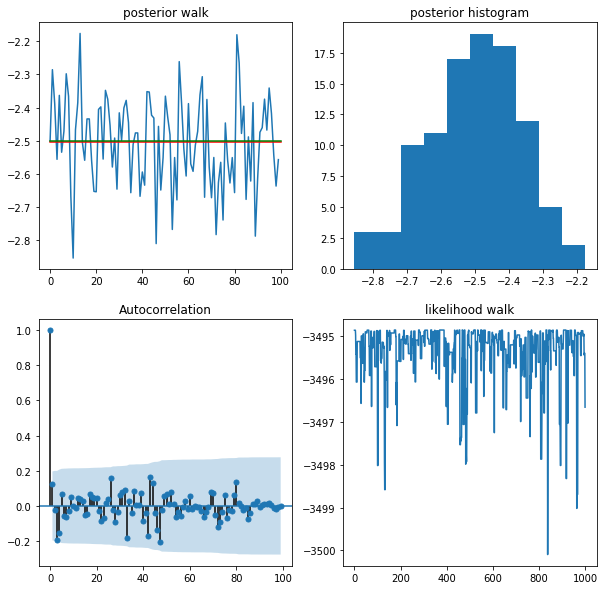

In [299]:
post = model.getPosterior(thin=0.1)
like = model.getLikelihood()

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot(post)
plt.plot([0, len(post)], [np.mean(post), np.mean(post)],color="red")
plt.plot([0, len(post)], [theta_true,theta_true],color="green")
plt.title("posterior walk")

plt.subplot(2,2,2)
plt.hist(post)
plt.title("posterior histogram")


ax2 = plt.subplot(2,2,3)
plot_acf(post, ax = ax2)

plt.subplot(2,2,4)
plt.plot(like)
plt.title("likelihood walk")




plt.show()

## How does the likelihood estimate depend on $N_\text{data}$?

N:1     -35.104941
N:10    -34.982500
N:25    -34.929990
N:50    -34.969610
N:75    -34.940225
N:100   -34.948548
dtype: float64


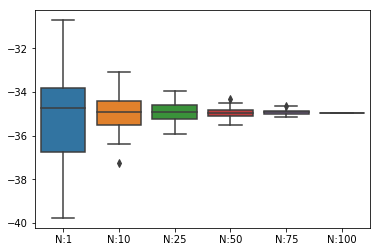

In [304]:
N_vec = [1,10,25,50,75,100]
theta = -2.5
rep = 100
df_like = pd.DataFrame({"id":range(rep)})

for i in N_vec:
    likeMean = []
    for j in range(rep):
        # we also divide by i to get the "mean"
        likeMean.append(model.likelihood(z_obs[np.random.choice(N_data, i, replace=False),:], theta) / i) 
    df_like["N:" + str(i)] = likeMean 
    
print(df_like.iloc[:,1:].mean())
sns.boxplot(data=df_like.iloc[:,1:])
plt.show()

### An accuracy estimate

In [120]:
def comp_bias(post, truth):
    bias = np.mean(post) - truth
    return(bias)

print("MAP: ", np.mean(post))
print("bias: ", comp_bias(post, theta_true))

MAP:  -2.627553661351483
bias:  -0.12755366135148316


We see that the solution in convering to the wrong answer.

# How does the error (|bias|) converge as $N_\text{data}$ increases

In [317]:
N_vec = np.linspace(1,100,5)
theta_start = -2.5
rep = 100
df_bias = pd.DataFrame({"id":range(rep)})

## MCMC parameters
N_sample = 1000
step = 4.5

np.random.seed(0)
for i in N_vec:
    print(i)
    biasEst = []
    for j in range(rep):
        model.reSeed(np.random.randint(1000))
        model.fit(z_obs[range(int(i)),:], N_sample, theta_start, step, silent=True)
        posterior = model.getPosterior()
        biasEst.append(comp_bias(posterior, theta_true))
    df_bias["N:" + str(i)] = np.abs(biasEst)




1.0
25.75
50.5
75.25
100.0


IndexError: list assignment index out of range

N:  1 mean:	 5.4873 	std:  0.6539
N:  25 mean:	 0.2474 	std:  0.0358
N:  50 mean:	 0.1015 	std:  0.0362
N:  75 mean:	 0.0691 	std:  0.0303
N:  100 mean:	 0.0268 	std:  0.0047


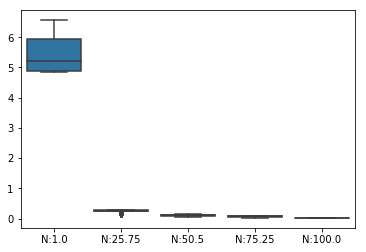

In [318]:
meanvec = []
stdvec = []
for i in range(len(N_vec)):
    meanvec.append(df_bias.iloc[:,i+1].mean())
    stdvec.append(df_bias.iloc[:,i+1].std())
    print("N: ", int(N_vec[i]), "mean:\t", np.round(meanvec[i],4), "\tstd: ", np.round(stdvec[i],4))

sns.boxplot(data=df_bias.iloc[:,1:])
plt.show()

In [327]:
print(meanvec)
print(N_vec)

[5.487271020180515, 0.24741914494782866, 0.10148031171203195, 0.0691022324354642, 0.026833551528032285]
[  1.    25.75  50.5   75.25 100.  ]


[]

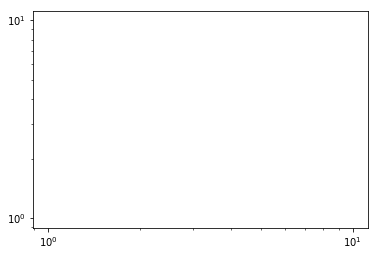

In [332]:
plt.loglog(x=N_vec, y=meanvec)

## How does the error converge as $\Delta t \rightarrow 0$?

In [21]:
delta_T = 1e-4
#bias = np.empty(len(delta_T_vec))

N_sample = 10000
start = -2.5

N_steps = 8
step_vec = [0.12, 0.22, 0.4, 0.7, 1.2, 3, 10, 10]


theta_true = -2.5
scale = 0.5

log = True


#delta_T_i = delta_T_vec[i]
#step_i = step_vec[i]
   
t_vec = np.linspace(0,1,int(1/delta_T))

y_true = model_analytic(theta_true, t_vec)

z_obs = observation(y_true, scale)


In [22]:
bias = np.empty(N_steps)
delta_T_vec = np.empty(N_steps)
model_list = []

by = 1
np.random.seed(0)
for i in range(N_steps):
    print(by)
    t_vec_i = t_vec[::by]
    delta_T_vec[i] = delta_T_i = delta_T*by
    z_obs_i = z_obs[::by]
    
    step_i = step_vec[i]
        
    model = MetropolisHastings(prior=Gprior(0, 10, log), noise=Gprior(0,scale, log), delta_T=delta_T_i, log=log)
    model.fit(z_obs_i, N_sample, start, step_i)
    
    model_list.append(model)
    
    post = model.getPosterior()
    bias[i] = comp_bias(post, theta_true)
    if(i % 2 == 0):
        by *= 5
    else:
        by *= 2
    

print("done")

1
run loop for:  10000


IndexError: tuple index out of range

In [ ]:
# fit a linear polynomial to the error
log_err = np.log(np.abs(bias))
log_dt = np.log(delta_T_vec)

p_fit = np.polyfit(log_dt, log_err, 1)
err_fit = np.exp(np.polyval(p_fit, log_dt))

print("lin. fit: ", p_fit)

In [ ]:
by = 1
x = []
for i in range(N_steps):
    x.append(1/np.sqrt(len(z_obs[::by])))
    if(i % 2 == 0):
        by *= 5
    else:
        by *= 2
x

In [ ]:
N_data_vec = 1/delta_T_vec
print("delta_T: ", delta_T_vec)
print("N_data: ", N_data_vec)

plt.loglog(N_data_vec,np.abs(bias), '.-b')
plt.loglog(N_data_vec, err_fit, '--r')
plt.loglog(N_data_vec, x, '-.g')
plt.legend(["error", "lin. fit", "1/sqrt(N_data)"])
plt.xlabel("N_data")
plt.ylabel("error")
plt.show()

In [ ]:
thin = 1
df_post = pd.DataFrame({"sample_id": range(int(N_sample*thin))})
post0 = model_list[0].getPosterior()
## add columns for each posterior sample
for i in range(N_steps):
    df_post["dt: " + str(delta_T_vec[i])] = model_list[i].getPosterior(thin=thin)

    


In [ ]:
df_post.head()

In [ ]:
model_list[0].plot()

In [ ]:
model_list[7].plot()

In [ ]:
thinned = 10
plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,2,1)
sns.kdeplot(df_post.iloc[::thinned,1])
sns.kdeplot(df_post.iloc[::thinned,2])
sns.kdeplot(df_post.iloc[::thinned,3])
sns.kdeplot(df_post.iloc[::thinned,4])

ax1 = plt.subplot(1,2,2)
sns.kdeplot(df_post.iloc[::thinned,5])
sns.kdeplot(df_post.iloc[::thinned,6])
sns.kdeplot(df_post.iloc[::thinned,7])
sns.kdeplot(df_post.iloc[::thinned,8])



plt.show()

these simulations suggests that each posterior converges to a mean that is not $\lambda$ but $\lambda_{\Delta t}$ 

In [ ]:
for col in df_post.columns[1:]:
    mean = df_post.loc[::10,[col]].mean()[0]
    std = df_post.loc[::10,[col]].std()[0]
    print(col, "\t, mean: ", np.round(mean,4), ",\t std: ", np.round(std,4))
